#### Extract features with VGG16

Use transfer learning based on a pre-trained network, we chose VGG16 network, in the following 2 manners.

Data preprocessing.

In [2]:
import cv2 as cv2
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
import seaborn as sn
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC


Using TensorFlow backend.


In [3]:
path_train=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\train'
path_test=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\test'
labels=[os.path.basename(dir) for dir in glob.glob(path_train + '/*', recursive=True)]
width = 224
height = 224
channel = 3
dim = (width, height)

train_y=[]
train_x=[]
test_y=[]
test_x=[]

for idx,i in enumerate(labels):
    for im in glob.glob(path_train + '/'+ i +'/*.jpg', recursive=True):
        train_x.append(cv2.imread(im))
        train_y.append(idx)


for idx,i in enumerate(labels):
    for im in glob.glob(path_test + '/'+ i +'/*.jpg', recursive=True):
        test_x.append(cv2.imread(im))
        test_y.append(idx)


#INTER_AREA – resampling using pixel area relation
train_r_x = np.array([cv2.resize(im, dim, interpolation = cv2.INTER_AREA) for im in train_x])
test_r_x = np.array([cv2.resize(im, dim, interpolation = cv2.INTER_AREA) for im in test_x])

train_r_x = np.array([np.reshape(im,(224,224,channel)) for im in train_r_x])/255
test_r_x = np.array([np.reshape(im, (224,224,channel)) for im in test_r_x])/255

y_train_one_hot = to_categorical(train_y)
y_test_one_hot = to_categorical(test_y)

X_train, X_validation, y_train, y_validation = train_test_split(
    train_r_x, y_train_one_hot, train_size=0.85, random_state=42)

1) Freeze the weights of all the layers but the last fully connected layer
and fine-tune the weights of the last layer based on the same train
and validation sets employed before;

In [4]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [13]:
# Freeze the layers except the last layer
for layer in vgg_conv.layers[:-1]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000208F9875630> False
<keras.layers.convolutional.Conv2D object at 0x000002089CB96C50> False
<keras.layers.convolutional.Conv2D object at 0x000002089CBA7DA0> False
<keras.layers.pooling.MaxPooling2D object at 0x000002089CBA7748> False
<keras.layers.convolutional.Conv2D object at 0x000002089CC04DD8> False
<keras.layers.convolutional.Conv2D object at 0x000002089CC22A58> False
<keras.layers.pooling.MaxPooling2D object at 0x000002089CC04FD0> False
<keras.layers.convolutional.Conv2D object at 0x000002089CC00470> False
<keras.layers.convolutional.Conv2D object at 0x000002089CA20F98> False
<keras.layers.convolutional.Conv2D object at 0x000002089CC79CC0> False
<keras.layers.pooling.MaxPooling2D object at 0x000002089CCB6B00> False
<keras.layers.convolutional.Conv2D object at 0x000002089CCB6940> False
<keras.layers.convolutional.Conv2D object at 0x000002089CC894A8> False
<keras.layers.convolutional.Conv2D object at 0x000002089CC89E80> False
<ker

In [14]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                376335    
Total params: 15,091,023
Trainable params: 376,335
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model

es = EarlyStopping(monitor='val_loss', patience=5)
batch_sz = 32

history=model.fit(
    X_train,
    y_train,
    batch_size=batch_sz,
    epochs=10,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)
 
# Save the model
model.save('small_last4.h5')

Train on 1275 samples, validate on 225 samples
Epoch 1/20
1275/1275 [==============================] - 676s 531ms/step - loss: 2.0759 - acc: 0.4345 - val_loss: 1.6361 - val_acc: 0.6356
Epoch 2/20
1275/1275 [==============================] - 593s 465ms/step - loss: 1.2165 - acc: 0.7702 - val_loss: 1.2012 - val_acc: 0.7156
Epoch 3/20
1275/1275 [==============================] - 583s 457ms/step - loss: 0.8347 - acc: 0.8478 - val_loss: 0.9574 - val_acc: 0.7556
Epoch 4/20
1275/1275 [==============================] - 597s 468ms/step - loss: 0.6173 - acc: 0.8886 - val_loss: 0.8728 - val_acc: 0.7422
Epoch 5/20
1275/1275 [==============================] - 602s 472ms/step - loss: 0.4805 - acc: 0.9239 - val_loss: 0.7472 - val_acc: 0.7689
Epoch 6/20
1275/1275 [==============================] - 604s 473ms/step - loss: 0.3824 - acc: 0.9388 - val_loss: 0.6942 - val_acc: 0.7822
Epoch 7/20
1275/1275 [==============================] - 602s 472ms/step - loss: 0.3043 - acc: 0.9561 - val_loss: 0.6605 - val

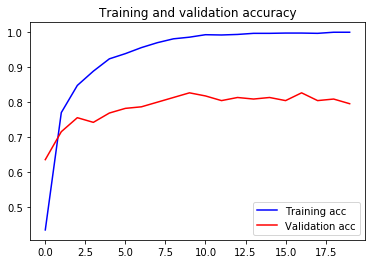

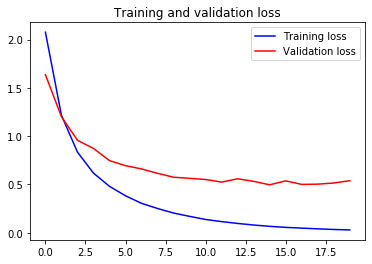

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

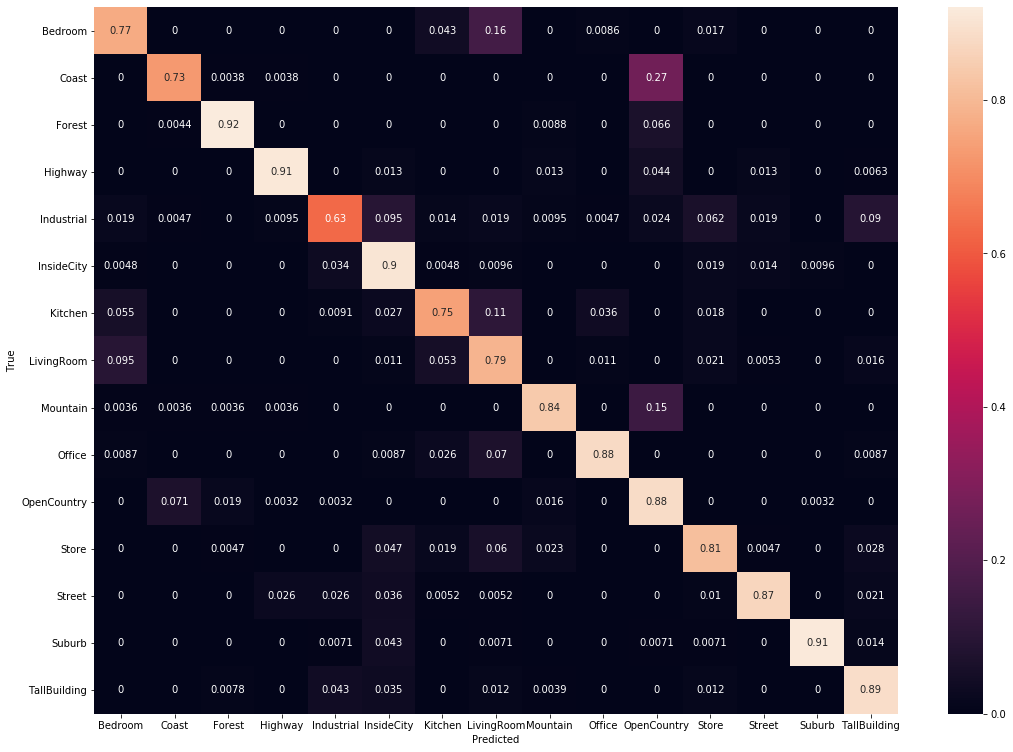

In [20]:
y_pred = model.predict_classes(test_r_x)
cm=confusion_matrix(test_y, y_pred)
# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]
plt.figure(figsize=(18,13))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");
plt.savefig("confusion matrix");


In [21]:
loss0,accuracy0 = model.evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

2985/2985 [==============================] - 4665s 2s/step
loss: 0.48
accuracy: 0.83


Employ the pre-trained network as a feature extractor, and train a multiclass linear SVM.

We are going to extract features obtained in the last convolutional layer of the VGG16. for each image, we will obtain 512 features, each of them is
a 7x7 grid of values. To make these feature suitable for a SVM, we will
flatten all the 512 features related to a specific image in a unique long vector.

In [5]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the model
model_extractor = models.Sequential()
 
# Add the vgg convolutional base model
model_extractor.add(vgg_conv)
 
# Add new layers
model_extractor.add(layers.Flatten())
model_extractor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [47]:
#extract the features
features_train = model_extractor.predict(train_r_x)
feature_test = model_extractor.predict(test_r_x)

In [6]:
# Create a linear SVM classifier 
lin_clf = LinearSVC()
# train the SVM
lin_clf.fit(features_train, train_y)

In [49]:
# the default 
y_pred=lin_clf.predict(feature_test)

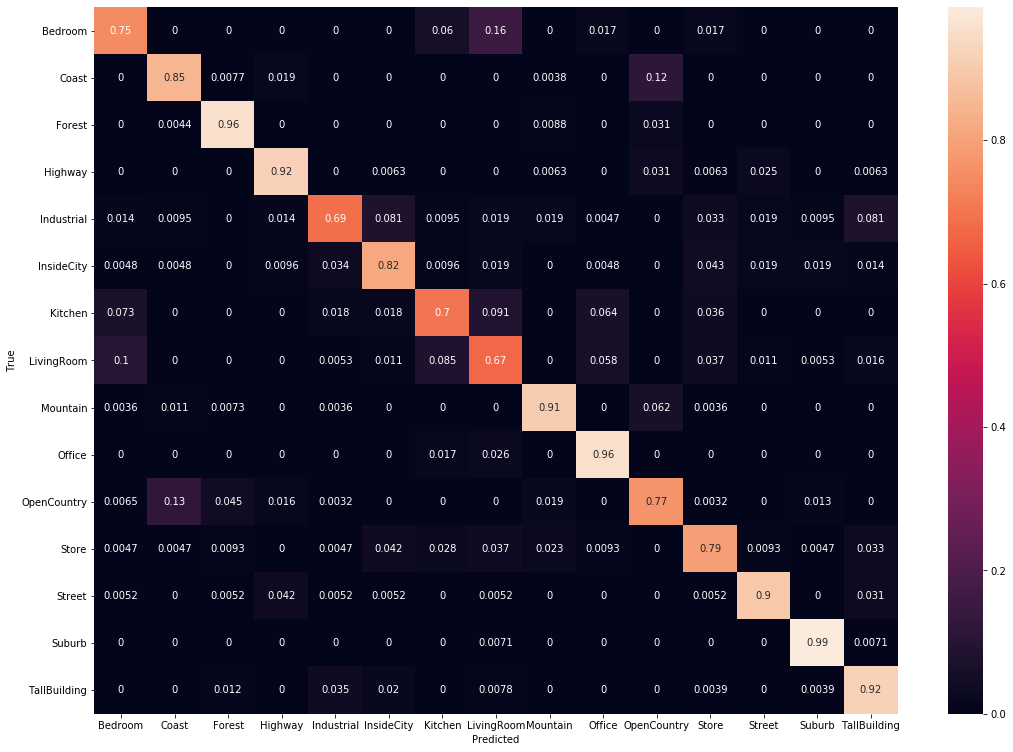

In [50]:
cm=confusion_matrix(test_y, y_pred)
# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]
plt.figure(figsize=(18,13))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");
plt.savefig("confusion matrix 2");

In [51]:
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

     Bedroom       0.71      0.75      0.73       116
       Coast       0.82      0.85      0.84       260
      Forest       0.90      0.96      0.93       228
     Highway       0.86      0.92      0.89       160
  Industrial       0.86      0.69      0.77       211
  InsideCity       0.82      0.82      0.82       208
     Kitchen       0.69      0.70      0.69       110
  LivingRoom       0.71      0.67      0.69       189
    Mountain       0.93      0.91      0.92       274
      Office       0.82      0.96      0.88       115
 OpenCountry       0.80      0.77      0.78       310
       Store       0.83      0.79      0.81       215
      Street       0.91      0.90      0.91       192
      Suburb       0.91      0.99      0.95       141
TallBuilding       0.86      0.92      0.89       256

    accuracy                           0.84      2985
   macro avg       0.83      0.84      0.83      2985
weig